#Notebook Overview

This is a simplified notebook that loads the embeddings of the graph neural network, as well as the model files of the dense neural networks. Thus, no training occurs in this notebook.

If you are interested in training the model, please refer to other versions of the notebook that include training functionality.

# Import Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import math
!pip install torch==2.2.1+cu121 torchvision==0.13.1+cu121 torchaudio==0.12.1+cu121 -f https://download.pytorch.org/whl/cu121/torch_stable.html
!pip install torch-geometric
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.2.1+cu121.html
import torch
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.metrics import roc_curve, auc, precision_score, recall_score, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

print(torch.__version__)
print(torch.version.cuda)

Looking in links: https://download.pytorch.org/whl/cu121/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torchvision==0.13.1+cu121 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.0+cu121, 0.16.1, 0.16.1+cu121, 0.16.2, 0.16.2+cu121, 0.17.0, 0.17.0+cu121, 0.17.1, 0.17.1+cu121, 0.17.2, 0.17.2+cu121)
ERROR: No matching distribution found for torchvision==0.13.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 58.5 MB/s eta 0:00:00
2.2.1+cu121
12.1


# Download and Process Data

## Helper Functions

In [24]:
def download_file(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)

def read_data(file_path):
    with open(file_path, 'r') as file:
        return [line.strip().split() for line in file.readlines()]

def download_model_file(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

## Datapaths

In [25]:
urls = {
    'train': 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/data5/train.txt',
    'test' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/data5/test.txt',
    'valid' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/data5/valid.txt',
    'full_pos2': 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/full_pos2.txt',
    'all_neg2': 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/all_neg2.txt',
    'enzyme' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Similarity%20Matrices/enzyme.txt',
    'pathway' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Similarity%20Matrices/pathway.txt',
    'substructure' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Similarity%20Matrices/substructure.txt',
    'target' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Similarity%20Matrices/target.txt',
    'drugs' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Encoded%20Features%20Data/DrugList.txt',
    'events' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Encoded%20Features%20Data/event_number.csv',
    'enzyme_pca' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/enzyme_PCA.csv',
    'pathway_pca' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/pathway_PCA.csv',
    'substructure_pca' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/smile_PCA.csv',
    'target_pca' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/target_PCA.csv'
    #'walks' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/data5/walks.txt'
}

model_urls = {
    'enzyme_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/enzyme_model_best_model.pth',
    'pathway_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/pathway_model_best_model.pth',
    'substructure_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/substructure_model_best_model.pth',
    'target_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/target_model_best_model.pth'
}

## Download

In [4]:
# Download the text files
for key, url in urls.items():
    download_file(url, f"{key}.txt")

In [26]:
# Download the models
for key, url in model_urls.items():
    download_file(url, f"{key}.pth")

## Process similarity matrices

In [6]:
import pandas as pd

def load_similarity_matrix(file_path):
    file_name = file_path.split('/')[-1]  #Get just file name from path

    with open(file_path, 'r') as file:
        lines = file.readlines()
        #take the first line as the dimensions
        dimensions = lines[0].strip().split()
        rows, cols = int(dimensions[0]), int(dimensions[1])
        print(f'Working on {file_name}: dimensions {rows}x{cols}')

        #the rest of the lines contain the matrix
        data = []
        for i, line in enumerate(lines[1:]):
            row_data = line.strip().split()[1:]  # Skip the row number

            #convert to float and handle scientific notation
            try:
                row_data = [float(x) for x in row_data]
            except ValueError as e:
                print(f"Error in line {i+2}: {e}")
                continue

            if len(row_data) != cols:
                raise ValueError(f"Row {i+2} does not contain {cols} values. Row data: {row_data}")

            data.append(row_data)

        # Convert to DataFrame
        matrix = pd.DataFrame(data)
        if matrix.shape != (rows, cols):
            raise ValueError(f"Data does not match specified dimensions {rows}x{cols}")
        return matrix

enzyme_matrix = load_similarity_matrix('/content/enzyme.txt')
pathway_matrix = load_similarity_matrix('/content/pathway.txt')
substructure_matrix = load_similarity_matrix('/content/substructure.txt')
target_matrix = load_similarity_matrix('/content/target.txt')


print('Enzyme Matrix first 5 lines:')
print(enzyme_matrix.head())

Working on enzyme.txt: dimensions 572x572
Working on pathway.txt: dimensions 572x572
Working on substructure.txt: dimensions 572x572
Working on target.txt: dimensions 572x572
Enzyme Matrix first 5 lines:
        0         1         2         3         4         5         6    \
0  4.593168 -0.541539 -0.419176 -0.585470  0.635045 -0.553429 -0.638244   
1 -1.746907 -0.047556  0.115552  0.256290  0.833815  0.055187 -0.252872   
2 -1.604115  0.854200  0.054576  0.923948 -0.645173 -0.069596 -0.404109   
3 -1.769781 -0.921454 -0.756435 -0.686417  0.678216 -0.013575  0.142495   
4  3.707746  2.830004 -0.844595  0.383860 -0.122485 -0.528834  0.652127   

        7         8         9    ...           562           563  \
0  0.058711  0.458386  0.214047  ...  0.000000e+00 -4.857226e-17   
1  0.095018 -0.013088  0.119412  ...  3.209238e-17 -1.561251e-17   
2 -0.331794  0.545126  0.175939  ... -1.561251e-17  1.734723e-18   
3 -0.032153 -0.427615 -0.124185  ...  6.938894e-18  1.023487e-16   
4  0.

## Load PCA data

In [7]:
def load_pca_matrix(file_path):
    df = pd.read_csv(file_path, header=None)
    print(f'Loaded PCA matrix with shape: {df.shape}')
    return df

enzyme_pca_matrix = load_pca_matrix('/content/enzyme_pca.txt')
pathway_pca_matrix = load_pca_matrix('/content/pathway_pca.txt')
substructure_pca_matrix = load_pca_matrix('/content/substructure_pca.txt')
target_pca_matrix = load_pca_matrix('/content/target_pca.txt')

print('Enzyme Matrix first 5 lines:')
print(enzyme_pca_matrix.head())

Loaded PCA matrix with shape: (572, 572)
Loaded PCA matrix with shape: (572, 572)
Loaded PCA matrix with shape: (572, 572)
Loaded PCA matrix with shape: (572, 572)
Enzyme Matrix first 5 lines:
        0         1         2         3         4         5         6    \
0 -2.372587 -0.760780 -0.714984 -0.109167  0.021720  2.112159 -0.542277   
1  6.204851 -2.078091  0.554921 -0.015221 -0.270164  0.069895 -0.081491   
2  0.179202  2.994849 -1.541727 -0.097438 -0.667955  0.331981  0.150204   
3 -2.009759  2.068614  1.574304 -1.298267 -1.671641 -0.841606  0.140530   
4 -0.335274  2.517403 -1.728993  0.250544  1.005359 -0.740888  0.092745   

        7         8         9    ...           562           563  \
0 -0.125736 -0.722250 -0.047426  ...  6.433290e-18  4.487866e-18   
1  0.046934  0.230890 -0.443133  ... -4.252929e-17  3.379733e-17   
2 -0.049210  0.606827  0.339442  ...  2.790049e-17  2.090791e-17   
3 -0.167539 -0.476125 -0.353863  ...  1.460076e-17  7.901071e-18   
4  0.658813  0.1

## Process training and test data

In [8]:
# Define a function to load the data into a DataFrame and label the columns
def load_data(file_path, has_interaction=True, has_event_num=True):
    #testing data, which can have 0 or 1 interactions
    if has_event_num and has_interaction:
        column_names = ['event_num', 'drug1', 'drug2', 'interaction']
    #training data which does not include interaction because it's always 1
    elif has_event_num:
        column_names = ['event_num', 'drug1', 'drug2']
    #All neg which only contains drug1, drug 2 and no interactions or events
    else:
        column_names = ['drug1', 'drug2']

    data = pd.read_csv(file_path, sep=' ', header=None, names=column_names)

    return data

# Paths to the files in the Colab environment
test_file_path = '/content/test.txt'
train_file_path = '/content/train.txt'
valid_file_path = '/content/valid.txt'
all_neg_file_path = '/content/all_neg2.txt'
full_pos_file_path = '/content/full_pos2.txt'

# Load the data into DataFrames
test_df = load_data(test_file_path, has_interaction=True)
train_df = load_data(train_file_path, has_interaction=False)
valid_df = load_data(valid_file_path, has_interaction=True)
all_neg_df = load_data(all_neg_file_path, has_interaction=False, has_event_num=False)
full_pos_df = load_data(full_pos_file_path, has_interaction=False)

print("Test DataFrame:")
print(test_df.head())
print('\n')
print("Train DataFrame:")
print(train_df.head())
print('\n')
print(f'train drug1 range: {train_df.drug1.min()}-{train_df.drug1.max()}')
print(f'train drug2 range: {train_df.drug2.min()}-{train_df.drug2.max()}')

Test DataFrame:
   event_num  drug1  drug2  interaction
0          0    114    535            1
1          0    185    535            1
2          0    199    535            1
3          0    506    535            1
4          0    411    535            1


Train DataFrame:
   event_num  drug1  drug2
0          0    541    280
1          0    541     43
2          0    541     91
3          0    541    256
4          0    541    571


train drug1 range: 0-571
train drug2 range: 0-571


## Process Encoded Data

In [9]:
drugs_df = pd.read_csv('/content/drugs.txt', header=None, names=['drug_name'])
drugs_df.reset_index(inplace=True)
drugs_df.rename(columns={'index': 'drug_number'}, inplace=True)

events_df = pd.read_csv('/content/events.txt')
events_df.reset_index(inplace=True)
events_df.rename(columns={'index': 'event_num', 'event': 'event_description', 'number': 'num_of_events_in_data'}, inplace=True)

## Evaluate leakage

In [10]:
# Normalize the drug pairs so that drug1 < drug2
def create_pair_set(df):
    return set(frozenset([row['drug1'], row['drug2']]) for _, row in df.iterrows())

# Create sets of drug pairs for each DataFrame
full_pos_pairs = create_pair_set(full_pos_df)
train_pairs = create_pair_set(train_df)
test_pairs = create_pair_set(test_df)
valid_pairs = create_pair_set(valid_df)

# Calculate the overlap between full_pos and train/test/valid sets
train_overlap = full_pos_pairs.intersection(train_pairs)
test_overlap = full_pos_pairs.intersection(test_pairs)
valid_overlap = full_pos_pairs.intersection(valid_pairs)

# Calculate the percentage of overlap
train_overlap_percentage = len(train_overlap) / len(train_pairs) * 100
test_overlap_percentage = len(test_overlap) / len(test_pairs) * 100
valid_overlap_percentage = len(valid_overlap) / len(valid_pairs) * 100

print(f"Percentage of train set overlapping with full_pos: {train_overlap_percentage:.2f}%")
print(f"Percentage of test set overlapping with full_pos: {test_overlap_percentage:.2f}%")
print(f"Percentage of validation set overlapping with full_pos: {valid_overlap_percentage:.2f}%")

Percentage of train set overlapping with full_pos: 100.00%
Percentage of test set overlapping with full_pos: 50.00%
Percentage of validation set overlapping with full_pos: 50.00%


## Evaluate Train/Test overlap

In [11]:
def create_pair_set(df):
    return set(frozenset([row['drug1'], row['drug2']]) for _, row in df.iterrows())

#create sets of drug pairs for each DataFrame
train_pairs = create_pair_set(train_df)
valid_pairs = create_pair_set(valid_df)
test_pairs = create_pair_set(test_df)

#Calculate the overlap between train and valid/test sets
train_valid_overlap = train_pairs.intersection(valid_pairs)
train_test_overlap = train_pairs.intersection(test_pairs)

#percentage of overlap
train_valid_overlap_percentage = len(train_valid_overlap) / len(train_pairs) * 100
train_test_overlap_percentage = len(train_test_overlap) / len(train_pairs) * 100

print(f"Percentage of train set overlapping with validation set: {train_valid_overlap_percentage:.2f}%")
print(f"Percentage of train set overlapping with test set: {train_test_overlap_percentage:.2f}%")

Percentage of train set overlapping with validation set: 0.00%
Percentage of train set overlapping with test set: 0.02%


# New Train/Test/Validation Dataset generation (balanced training data)

In [12]:
#select equal number of negative examples from all_neg_df
num_negatives = len(full_pos_df)
all_neg_sample = all_neg_df.sample(n=num_negatives, random_state=42)

# Add an 'event_num' column with a placeholder value
all_neg_sample['event_num'] = -1

#Combine positive and negative examples for neural network training
nn_data = pd.concat([full_pos_df, all_neg_sample]).reset_index(drop=True)

#split data into train, validation, and test sets (70-10-20 split)
train_df, test_df = train_test_split(nn_data, test_size=0.3, random_state=2)
valid_df, test_df = train_test_split(test_df, test_size=(2/3), random_state=2)  #split last 30% into 10% and 20% valid/test

test_df['interaction'] = test_df['event_num'].apply(lambda x: 1 if 0 <= x <= 64 else 0)

# Verify the splits
print(f"Train data size: {len(train_df)}")
print(f"Validation data size: {len(valid_df)}")
print(f"Test data size: {len(test_df)}")

Train data size: 52169
Validation data size: 7453
Test data size: 14906


# Data Understanding

# **General Nomenclature**

1. **event_num**: a number between 0-64 that represents a particular interaction between two drugs (more information can be found in the events_df)
2. **drug1/drug2** : a number between 0-571 that represents the 572 drugs studied (names can be found in the drugs_df)
3. **interaction** : a binary (0/1) variable representing whether an interaction occurs or not between two drugs


# **Data structure for data used in this code**

**full_pos** : a collection of all known interactions, used for creating the graph.
*   Formatted as event_num, drug1, drug2
* length: 37,264

**all_neg** : a collection of all known non-interactions, used for creating the graph.
*   Formatted as drug1, drug2
* Note: this implies no reaction for ALL event_nums
* length: 37,264

**train** : a collection of training data used for training the dense neural network
*   Formatted as event_num, drug1, drug2
* Note: all data in here is implictly interaction:1 (meaning there is an interaction between these two drugs of type event_num)
* length: 24,196

**valid** : a collection of validation data used for validating the training of the dense neural network
*   Formatted as event_num, drug1, drug2, interaction
* Note: 50% of this data is interaction:1 and found on the graph, 50% is interaction 0, and thus not on the graph
* length: 11,198

**test** : a collection of test data used for assessing the capabilities of the full model
*   Formatted as event_num, drug1, drug2, interaction
* Note: 50% of this data is interaction:1 and found on the graph, 50% is interaction 0, and thus not on the graph
* length: 14,948

# **Points of Clarification**

drug1, drug2 are interchangeable. This means our graph is undirected


In [13]:
events_df.head()

,event_num,event_description,num_of_events_in_data
0,0,The metabolism of name can be decreased when c...,19620
1,1,The risk or severity of adverse effects can be...,18992
2,2,The serum concentration of name can be increas...,11292
3,3,The serum concentration of name can be decreas...,4772
4,4,The therapeutic efficacy of name can be decrea...,2624


In [14]:
drugs_df.head()

,drug_number,drug_name
0,0,Abemaciclib
1,1,Amiodarone
2,2,Apalutamide
3,3,Aprepitant
4,4,Atomoxetine


# General parameters for the model

In [15]:
embedding_dim = 32  #Default 32
event_num = 65  #Default 65 DO NOT CHANGE

#Dictionary of feature matrices to use
feature_matrices = {
    'enzyme': enzyme_matrix,
    'pathway': pathway_matrix,
    'substructure': substructure_matrix,
    'target': target_matrix,
}

pca_matrices = {
    'enzyme': enzyme_pca_matrix,
    'pathway': pathway_pca_matrix,
    'substructure': substructure_pca_matrix,
    'target': target_pca_matrix,
}


#Use GPU if available. This will be much faster for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Choose how to obtain Graph Embeddings

Now we will create graph embeddings. This will serve as the raw feature vector into our feed forward neural network.

There are two options for creating these embeddings:


1.   Run the "Define Graph Neural Network and create custom embeddings" code blocks and create your own embeddings
2.   Run the "OR, Load pre-calculated graph embeddings" and load pre-computed embeddings

You DO NOT need to run both. Either way, you will end up with 572x2080 embedding matrices.

If you choose to run the graph neural network, you will make a graph of nodes (drugs) and edges (events - event num). Four graphs in total are made (one for each of the properties we want to make embeddings for - enzyme, pathway, substructure, and target). The features of the nodes on the graph will be a column of the feature matrix, corresponding to it's similarity to each of the other drugs in the network on that property (enzyme for instance). A random walk of the graph with a context window is used to create the embeddings.

The output dimension of these graph embeddings is 572x32x65 which corresponds to the number of drugs x the embedding dimension x the number of events. The embedding dimension is a tuned hyperparameter from the original work, but can theoretically be changed. Finally, the last two dimensions of these matrices will be concatenated to form raw feature vectors for the nerual network (of dimension 572x2080 where 2080=32x65). "Raw" because we will still need to perform some further operations before they are ready to go. This process is represented pictorially below: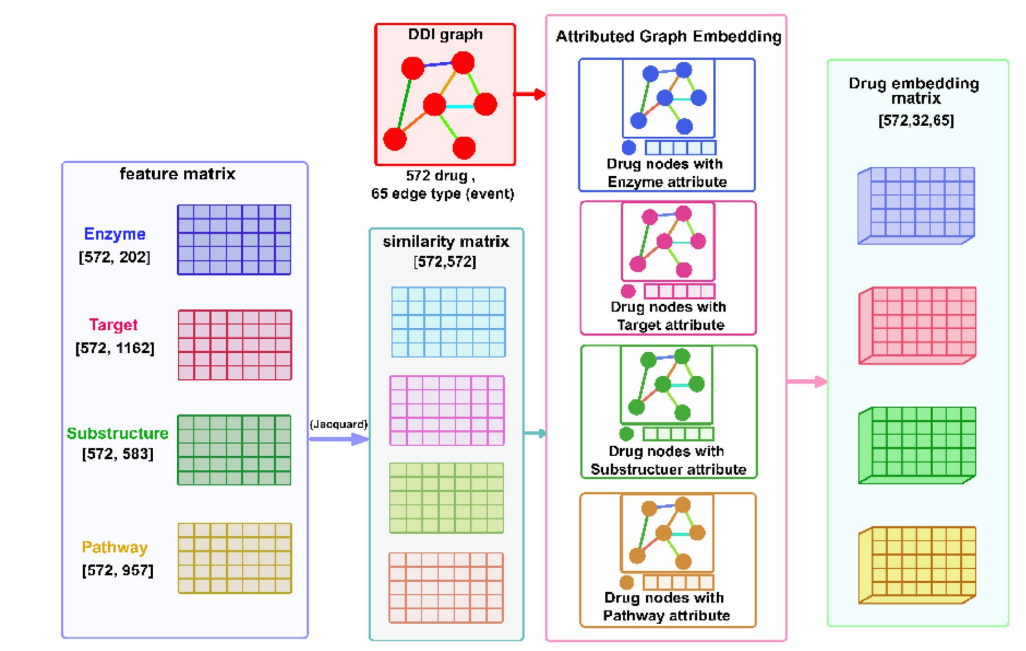

#Load pre-calculated graph embeddings

In [16]:
urls = {
    'enzyme_embedding_matrix': 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Embedding%20Matrices/enzyme_drug_embedding_matrix.csv',
    'target_embedding_matrix': 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Embedding%20Matrices/target_drug_embedding_matrix.csv',
    'substructure_embedding_matrix': 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Embedding%20Matrices/substructure_drug_embedding_matrix.csv',
    'pathway_embedding_matrix': 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Embedding%20Matrices/pathway_drug_embedding_matrix.csv',
}

embedding_matrices = {}

for key, url in urls.items():
    embedding_matrices[key] = pd.read_csv(url, header=None)


enzyme_df = embedding_matrices['enzyme_embedding_matrix']
target_df = embedding_matrices['target_embedding_matrix']
substructure_df = embedding_matrices['substructure_embedding_matrix']
pathway_df = embedding_matrices['pathway_embedding_matrix']

print(f'drug embedding matrices of shape {enzyme_df.shape}')
print('enzyme_df:')
print(enzyme_df.head())

drug embedding matrices of shape (572, 2080)
enzyme_df:
       0         1         2         3         4         5         6     \
0 -0.134519  0.072731 -0.115689  0.277850  0.144056 -0.133885  0.308257   
1 -0.109487  0.066786 -0.079493  0.308510  0.124736 -0.145775  0.332964   
2 -0.132088  0.068527 -0.115999  0.259763  0.158878 -0.143569  0.297094   
3 -0.159063  0.096467 -0.104562  0.270554  0.095969 -0.096957  0.346782   
4 -0.152987  0.105926 -0.121674  0.257951  0.136562 -0.107454  0.326656   

       7         8         9     ...      2070      2071      2072      2073  \
0 -0.310177  0.206568  0.108368  ... -0.124596 -0.228497 -0.173285  0.108145   
1 -0.368566  0.170503  0.125484  ... -0.169279 -0.275377 -0.195528  0.198414   
2 -0.312255  0.209851  0.109100  ... -0.231555 -0.091012 -0.198595  0.178463   
3 -0.288660  0.191809  0.155859  ... -0.196904 -0.088627 -0.151063  0.249412   
4 -0.318284  0.189763  0.123710  ... -0.199105 -0.148257 -0.155831  0.144903   

       2074 

#Prepare for Neural Network

We currently have 572x2080 drug embedding matrices for each of the four properties we are using to help us predict if two drugs will interact (enzyme, pathway, substructure, and target). For each embedding matrix, we need to take a slice horizontally to represent the drug with all it's graph embedded event information (dimension 1x2080). This vector contains all the graph's embedded knowledge for ONE PARTICULAR drug. As this is a drug-drug interaction task, that won't quite be enough, so we now need to multiply it with each other drug to create the feature vectors for our neural network. We do this by elementwise multiplication of the vectors such that the end result will still be 1x2080.

The network:
For each vector of size 2080, we will do the following:


1.   Feed through a fully connected layer, outputing to 512 dim and sending through a ReLU activation function
2.   Batch normalizing
3.   Sending through a drouput layer to help with overfitting
4.   Repeat steps 1-3 above but with an output dimension of 256 for the fully connected layer
5.   Feed through one final fully connected layer to an output of event_num
6.   Take the softmax of this output, representing a probability vector for the drug-drug interaction at each of the event nums

Since this will be done for each of the four matrices, we can then take the average of the four vectors to obtain the final output into a binary vector of dimensions 1x65. This represents a 0-1 vector over the 65 possible interaction events, where a value close to 1 indicates a strong predicted interaction, and a value close to 0 predicts no interaction for those two drugs.





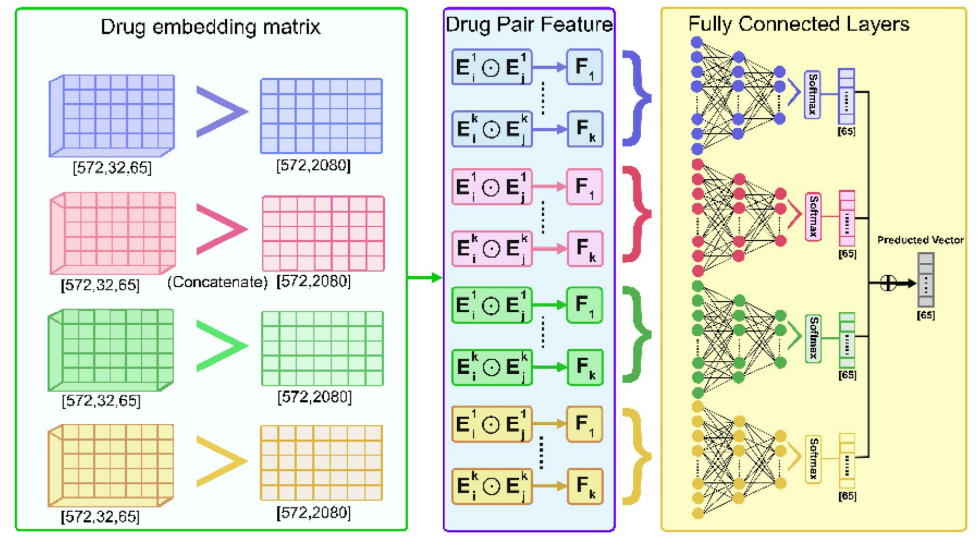

# Dense Neural Network

## Data loaders: Prepare data for output prediction

The neural network outputs a 1x65 dimensional output vectors that represent interaction or not over 65 event types. In order to prepare labels for training and test data, we will want the labels for the data to also be 1x65 tensors, with a 1 at the value of the event num for the two drugs.

**Training:**

The logic for training data is to just make a zeros tensor and one-hot encode the tensor at the event_num in the training data

**Testing:**

The logic for testing data is very similar to training. We start with zeros tensors for each of the four matrices (as the test will combine the output of all four models). If interaction = 1 we then one-hot encode at the index of event num. All four tensors are then passed back.

In [17]:
#Dataset for training cases
class DrugInteractionDataset(Dataset):
    def __init__(self, df, matrix):
        self.matrix = torch.tensor(matrix.values, dtype=torch.float32)
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        drug1_idx, drug2_idx, event_number = int(row['drug1']), int(row['drug2']), int(row['event_num'])

        #Create feature vector from the embeddings
        feature_vector = self.matrix[drug1_idx] * self.matrix[drug2_idx]

        #Create label tensor with a 1 at the index of event_num+1
        #Where a label at 0 indicates no interaction
        label = torch.zeros((event_num+1,), dtype=torch.float32)
        label[event_number+1] = 1.0

        return feature_vector, label

#Dataset for test cases
class TestInteractionDataset(Dataset):
    def __init__(self, df, enzyme_matrix, target_matrix, substructure_matrix, pathway_matrix):
        self.df = df
        self.enzyme_matrix = torch.tensor(enzyme_matrix.values, dtype=torch.float32)
        self.target_matrix = torch.tensor(target_matrix.values, dtype=torch.float32)
        self.substructure_matrix = torch.tensor(substructure_matrix.values, dtype=torch.float32)
        self.pathway_matrix = torch.tensor(pathway_matrix.values, dtype=torch.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        drug1_idx, drug2_idx, event_number, interaction = (
            int(row['drug1']),
            int(row['drug2']),
            int(row['event_num']),
            int(row['interaction'])
        )

        # Create feature vectors from the embeddings
        enzyme_feature_vector = self.enzyme_matrix[drug1_idx] * self.enzyme_matrix[drug2_idx]
        target_feature_vector = self.target_matrix[drug1_idx] * self.target_matrix[drug2_idx]
        substructure_feature_vector = self.substructure_matrix[drug1_idx] * self.substructure_matrix[drug2_idx]
        pathway_feature_vector = self.pathway_matrix[drug1_idx] * self.pathway_matrix[drug2_idx]

        #Create label tensor as a 66-dimensional zero tensor
        #65+1 to include the no reaction case
        label = torch.zeros(event_num+1, dtype=torch.float32)
        # Set to 1 at the event_num index if interaction is 1
        if interaction == 1:
            label[event_number+1] = 1.0
        else:
            label[0] = 1.0

        return (enzyme_feature_vector,
                target_feature_vector,
                substructure_feature_vector,
                pathway_feature_vector), label

In [18]:
nn_batch_size = 128

test_dataset = TestInteractionDataset(test_df, enzyme_df, target_df, substructure_df, pathway_df)

# Data loaders
enzyme_train_loader = DataLoader(DrugInteractionDataset(train_df, enzyme_df), batch_size=nn_batch_size, shuffle=True)
target_train_loader = DataLoader(DrugInteractionDataset(train_df, target_df), batch_size=nn_batch_size, shuffle=True)
substructure_train_loader = DataLoader(DrugInteractionDataset(train_df, substructure_df), batch_size=nn_batch_size, shuffle=True)
pathway_train_loader = DataLoader(DrugInteractionDataset(train_df, pathway_df), batch_size=nn_batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=nn_batch_size, shuffle=False)

## Define Neural Network Parameters

In [19]:
layer_1_dim = 512  #Default 512
layer_2_dim = 256 #Default 256
input_dim = embedding_dim * event_num # DO NOT CHANGE
output_dim = event_num+1 # DO NOT CHANGE
dropout = 0.3 #Default 0.3
learning_rate = 0.001 #Default 0.001 in Keras (what the paper uses)
num_epochs = 100 #Default 100
patience = 10 #Default 10
cross_fold_value = 5 #Default 5
state = 0 #random state for cross fold validation

## Neural Network definition

In [20]:
class DrugInteractionNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DrugInteractionNetwork, self).__init__()

        self.fc1 = nn.Linear(input_dim, layer_1_dim)
        self.bn1 = nn.BatchNorm1d(num_features=layer_1_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(layer_1_dim, layer_2_dim)
        self.bn2 = nn.BatchNorm1d(num_features=layer_2_dim)
        self.dropout2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(layer_2_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        #x = F.softmax(x)
        return x

## Instantiate models, optimizers, and criterions. Load into single dictionary for multi-processing

In [21]:
enzyme_model = DrugInteractionNetwork(input_dim, output_dim).to(device)
target_model = DrugInteractionNetwork(input_dim, output_dim).to(device)
substructure_model = DrugInteractionNetwork(input_dim, output_dim).to(device)
pathway_model = DrugInteractionNetwork(input_dim, output_dim).to(device)

enzyme_optimizer = optim.Adam(enzyme_model.parameters(), lr=learning_rate)
target_optimizer = optim.Adam(target_model.parameters(), lr=learning_rate)
substructure_optimizer = optim.Adam(substructure_model.parameters(), lr=learning_rate)
pathway_optimizer = optim.Adam(pathway_model.parameters(), lr=learning_rate)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

#create a dictionary of models and their corresponding data loaders and optimizers to aid in training loop
models_loaders_optimizers = {
    'enzyme_model': (enzyme_model, enzyme_train_loader, enzyme_optimizer),
    'target_model': (target_model, target_train_loader, target_optimizer),
    'substructure_model': (substructure_model, substructure_train_loader, substructure_optimizer),
    'pathway_model': (pathway_model, pathway_train_loader, pathway_optimizer),
}


#Load best trained models

In [27]:
map_location = 'cpu'

#load the best models found from cross validation
enzyme_model.load_state_dict(torch.load('/content/enzyme_model_best_model.pth', map_location=map_location))
target_model.load_state_dict(torch.load('/content/target_model_best_model.pth', map_location=map_location))
substructure_model.load_state_dict(torch.load('/content/substructure_model_best_model.pth', map_location=map_location))
pathway_model.load_state_dict(torch.load('/content/pathway_model_best_model.pth', map_location=map_location))

<All keys matched successfully>

# Testing and Evaluation

### Plotting function

In [28]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

### Test and print metrics and ROC curve

In [29]:
# Set models to evaluation mode
enzyme_model.eval()
target_model.eval()
substructure_model.eval()
pathway_model.eval()

all_scores = []
all_labels = []
all_predictions = []

with torch.no_grad():
    for features, labels in test_loader:
        enzyme_features, target_features, substructure_features, pathway_features = features

        #set feature vectors and send them to the device
        enzyme_features = enzyme_features.to(device)
        target_features = target_features.to(device)
        substructure_features = substructure_features.to(device)
        pathway_features = pathway_features.to(device)

        #get model outputs
        enzyme_outputs = enzyme_model(enzyme_features)
        target_outputs = target_model(target_features)
        substructure_outputs = substructure_model(substructure_features)
        pathway_outputs = pathway_model(pathway_features)

        #manually apply softmax to each output
        enzyme_outputs = F.softmax(enzyme_model(enzyme_features), dim=1)
        target_outputs = F.softmax(target_model(target_features), dim=1)
        substructure_outputs = F.softmax(substructure_model(substructure_features), dim=1)
        pathway_outputs = F.softmax(pathway_model(pathway_features), dim=1)

        #create a simple average of the 4 outputs as in the paper
        avg_outputs = (enzyme_outputs + target_outputs + substructure_outputs + pathway_outputs) / 4

        #find the max as an interaction prediction
        #print(avg_outputs)
        _, y_pred = torch.max(avg_outputs, dim=1)
        #print(y_pred)

        #append metrics to their respective containers
        all_scores.append(avg_outputs.cpu())
        all_predictions.append(y_pred.cpu())
        all_labels.append(labels.max(dim=1)[1].cpu())

#concatenate and convert to numpy arrays
all_scores_tensor = torch.cat(all_scores, dim=0)
all_predictions_tensor = torch.cat(all_predictions, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)

all_scores_np = torch.softmax(all_scores_tensor, dim=1).numpy()
all_predictions_np = all_predictions_tensor.numpy()
all_labels_np = all_labels_tensor.numpy()

#Use label_binarize to one hot encode
all_labels_one_hot = label_binarize(all_labels_np, classes=np.arange(event_num+1))

#calculate metrics
average_type = 'weighted'
accuracy = accuracy_score(all_labels_np, all_predictions_np)
precision = precision_score(all_labels_np, all_predictions_np, average=average_type, zero_division=0)
recall = recall_score(all_labels_np, all_predictions_np, average=average_type, zero_division=0)
f1 = f1_score(all_labels_np, all_predictions_np, average=average_type )

#ROC
roc_auc = roc_auc_score(all_labels_one_hot, all_scores_np, average='micro', multi_class='ovr')

#print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.9168120220045619
Precision: 0.9176589113092163
Recall: 0.9168120220045619
F1 Score: 0.9156332492440433
ROC AUC: 0.998733108472443


## Inspect Test Outcome


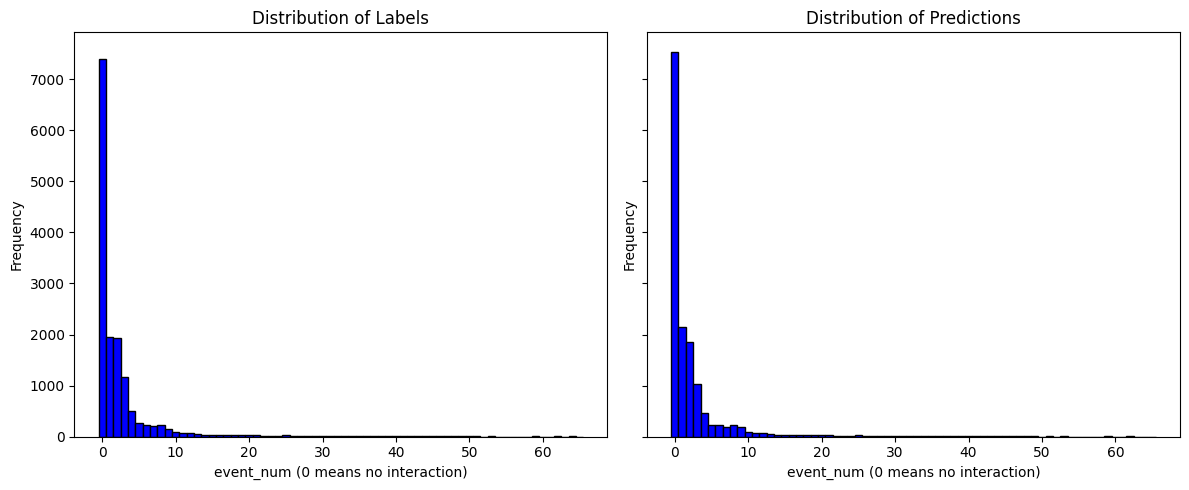

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

#labels subplot
axs[0].hist(all_labels_np, bins=range(int(min(all_labels_np)), int(max(all_labels_np)) + 2), align='left', color='blue', edgecolor='black')
axs[0].set_title('Distribution of Labels')
axs[0].set_xlabel('event_num (0 means no interaction)')
axs[0].set_ylabel('Frequency')

#predictions subplot
axs[1].hist(all_predictions_np, bins=range(int(min(all_predictions_np)), int(max(all_predictions_np)) + 2), align='left', color='blue', edgecolor='black')
axs[1].set_title('Distribution of Predictions')
axs[1].set_xlabel('event_num (0 means no interaction)')
axs[1].set_ylabel('Frequency')

#prevent overlap
plt.tight_layout()

#plot
plt.show()

ROC AUC (One vs Rest): 0.998733108472443


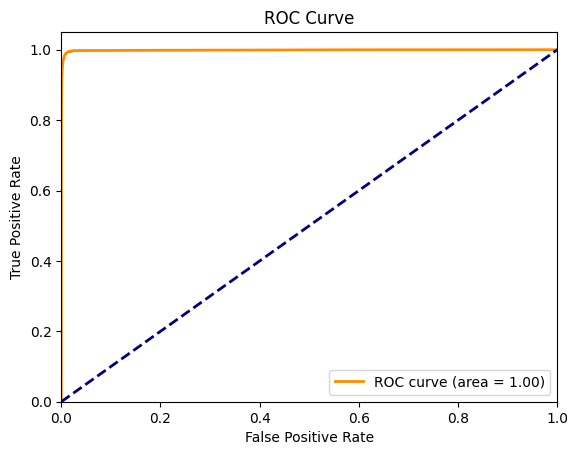

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

roc_auc_ovr = roc_auc_score(all_labels_one_hot, all_scores_np, average='micro', multi_class='ovr')
print(f'ROC AUC (One vs Rest): {roc_auc_ovr}')

#compute micro-average ROC curve and ROC area for plotting
fpr, tpr, _ = roc_curve(all_labels_one_hot.ravel(), all_scores_np.ravel())
roc_auc = auc(fpr, tpr)

#plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
